# 2: Human breast cancer_Clusting

HDVAE can process 10X Visium data to extract low-dimension representation. In this tutorial, we use HBC dataset to introduce the analysis. 

The raw breast cancer dataset can be downloaded from: https://www.10xgenomics.com/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0;

The complete experimental dataset is available here https://zenodo.org/records/15599070

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
import HDVAE
HDVAE.fix_seed(2023)

In [3]:
data_root = Path('../data/BRCA1')
data_dir = data_root / 'V1_Human_Breast_Cancer_Block_A_Section_1'
adata = sc.read_visium(path=data_dir , count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

In [5]:
#Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)  
sc.pp.log1p(adata)

from sklearn.decomposition import PCA
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

In [6]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'layer_guess'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'X_pca'

## Constructing the spatial network

In [7]:
# construct graph
graph_dict = HDVAE.graph_construction(adata, 6)

## Running HDVAE

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
hdvae_net = HDVAE.hdvae(adata.obsm['X_pca'], graph_dict, device=device)
hdvae_net.train_with_dec()
hdvae_feat, _, _, _ = hdvae_net.process()
adata.obsm['HDVAE'] = hdvae_feat

## Clusting

In [9]:
# HDVAE.configure_r_environment()   # set your path

In [10]:
HDVAE.mclust_R(adata, n_clusters=20, use_rep='HDVAE', key_added='HDVAE_clust')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'layer_guess', 'HDVAE_clust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'X_pca', 'HDVAE'

### Visualization

<Figure size 400x400 with 0 Axes>

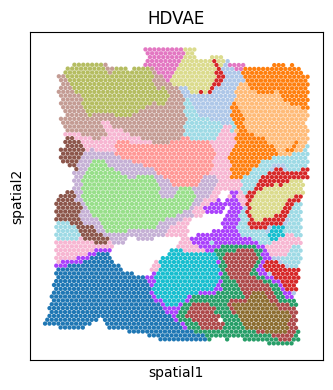

In [12]:
plt.rcParams.update({
    "figure.figsize": (4, 4),
    "figure.facecolor": "white",  
    "axes.facecolor": "white" 
})

plt.figure(facecolor='white')
sc.pl.spatial(
    adata,
    img_key=None,
    color="HDVAE_clust",
    size=1.5,
    title="HDVAE",
    frameon=True,           
    legend_loc=None,        
    show=False,         
)
plt.tight_layout()
# plt.savefig('HBC_spatial.png',dpi=300, bbox_inches='tight')

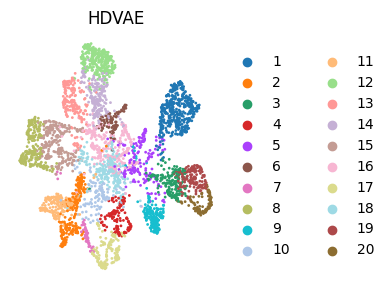

In [13]:
sc.pp.neighbors(adata, use_rep='HDVAE')
sc.tl.umap(adata)
plt.rcParams["figure.figsize"] = (4, 3)
sc.pl.umap(
    adata,
    color='HDVAE_clust',
    title='HDVAE',
    show=False,
    s=16,
    frameon=False
)
plt.tight_layout()
# plt.savefig('HBC_umap.png',dpi=300, bbox_inches='tight')

In [14]:
def get_cluster_markers(
    adata,
    cluster_key='HDVAE_clust',
    n_markers=3,
    pval_cutoff=1e-5,
    logfc_cutoff=2,
    allow_partial=True,
    key_added='diff_genes'
):
    sc.tl.rank_genes_groups(
        adata,
        groupby=cluster_key,
        method='wilcoxon',
        key_added=key_added,
        pts=True
    )

    clusters = adata.obs[cluster_key].cat.categories.astype(str).tolist()
    marker_df = pd.DataFrame()
    for cluster in clusters:
        try:
            de_df = sc.get.rank_genes_groups_df(
                adata,
                group=cluster,
                key=key_added
            ).sort_values('logfoldchanges', key=abs, ascending=False)
            
            filtered = de_df[
                (de_df['pvals_adj'] < pval_cutoff) &
                (de_df['logfoldchanges'].abs() > logfc_cutoff)
            ]
            
            if len(filtered) < n_markers:
                filtered = de_df[
                    (de_df['pvals_adj'] < 0.05) &
                    (de_df['logfoldchanges'].abs() > logfc_cutoff)
                ]
            
            top_genes = filtered.head(n_markers)['names'].tolist()
            if allow_partial:
                genes = top_genes
            else:
                genes = top_genes + [f'None_{i}' for i in range(n_markers - len(top_genes))]
            
            cluster_df = pd.DataFrame(
                [genes],
                columns=[f'Gene{i+1}' for i in range(n_markers)],
                index=[f'Cluster_{cluster}']
            )
            marker_df = pd.concat([marker_df, cluster_df])
            
        except Exception as e:
            print(f"Cluster {cluster} error: {str(e)}")
            continue
    
    return marker_df


n_markers=3
marker_df = get_cluster_markers(
    adata,
    n_markers=n_markers,
    pval_cutoff=1e-5,
    logfc_cutoff=1,
    allow_partial=False
)

selected_genes = [g for g in marker_df.values.flatten() if g is not None]
print(marker_df)

                Gene1       Gene2         Gene3
Cluster_1      ARPP21    Z82214.2         SPAG6
Cluster_2     SLC31A2       TRIT1        ZSCAN1
Cluster_3      CRISP3     SLITRK6  KIAA2012-AS1
Cluster_4        DSC3       MMP10         KRT6B
Cluster_5      CLEC3A       LIN7A         THBS4
Cluster_6       IGSF3      TSEN15     HIST1H2BC
Cluster_7         ALB        TCF4         PGGHG
Cluster_8   LINC00052  AC129507.4        SNAP25
Cluster_9    PGM5-AS1  AC087379.2         KRT37
Cluster_10       KRT5       KRT17         KRT14
Cluster_11     KIF20A      CHRDL1       NKIRAS1
Cluster_12     FCGR3B        CPB1         CELF3
Cluster_13  LINC00645        CDSN       RASSF10
Cluster_14       CPB1         LTF         NPY1R
Cluster_15       SYT1   MRPS30-DT         PDE5A
Cluster_16    RASGRP2        JAML          IL7R
Cluster_17       DLX2       KLK11     LINC02551
Cluster_18      IGLC2       IGHG3         IGLC3
Cluster_19     CRISP3  AC089998.4    AC089998.1
Cluster_20     CRISP3     SLITRK6       

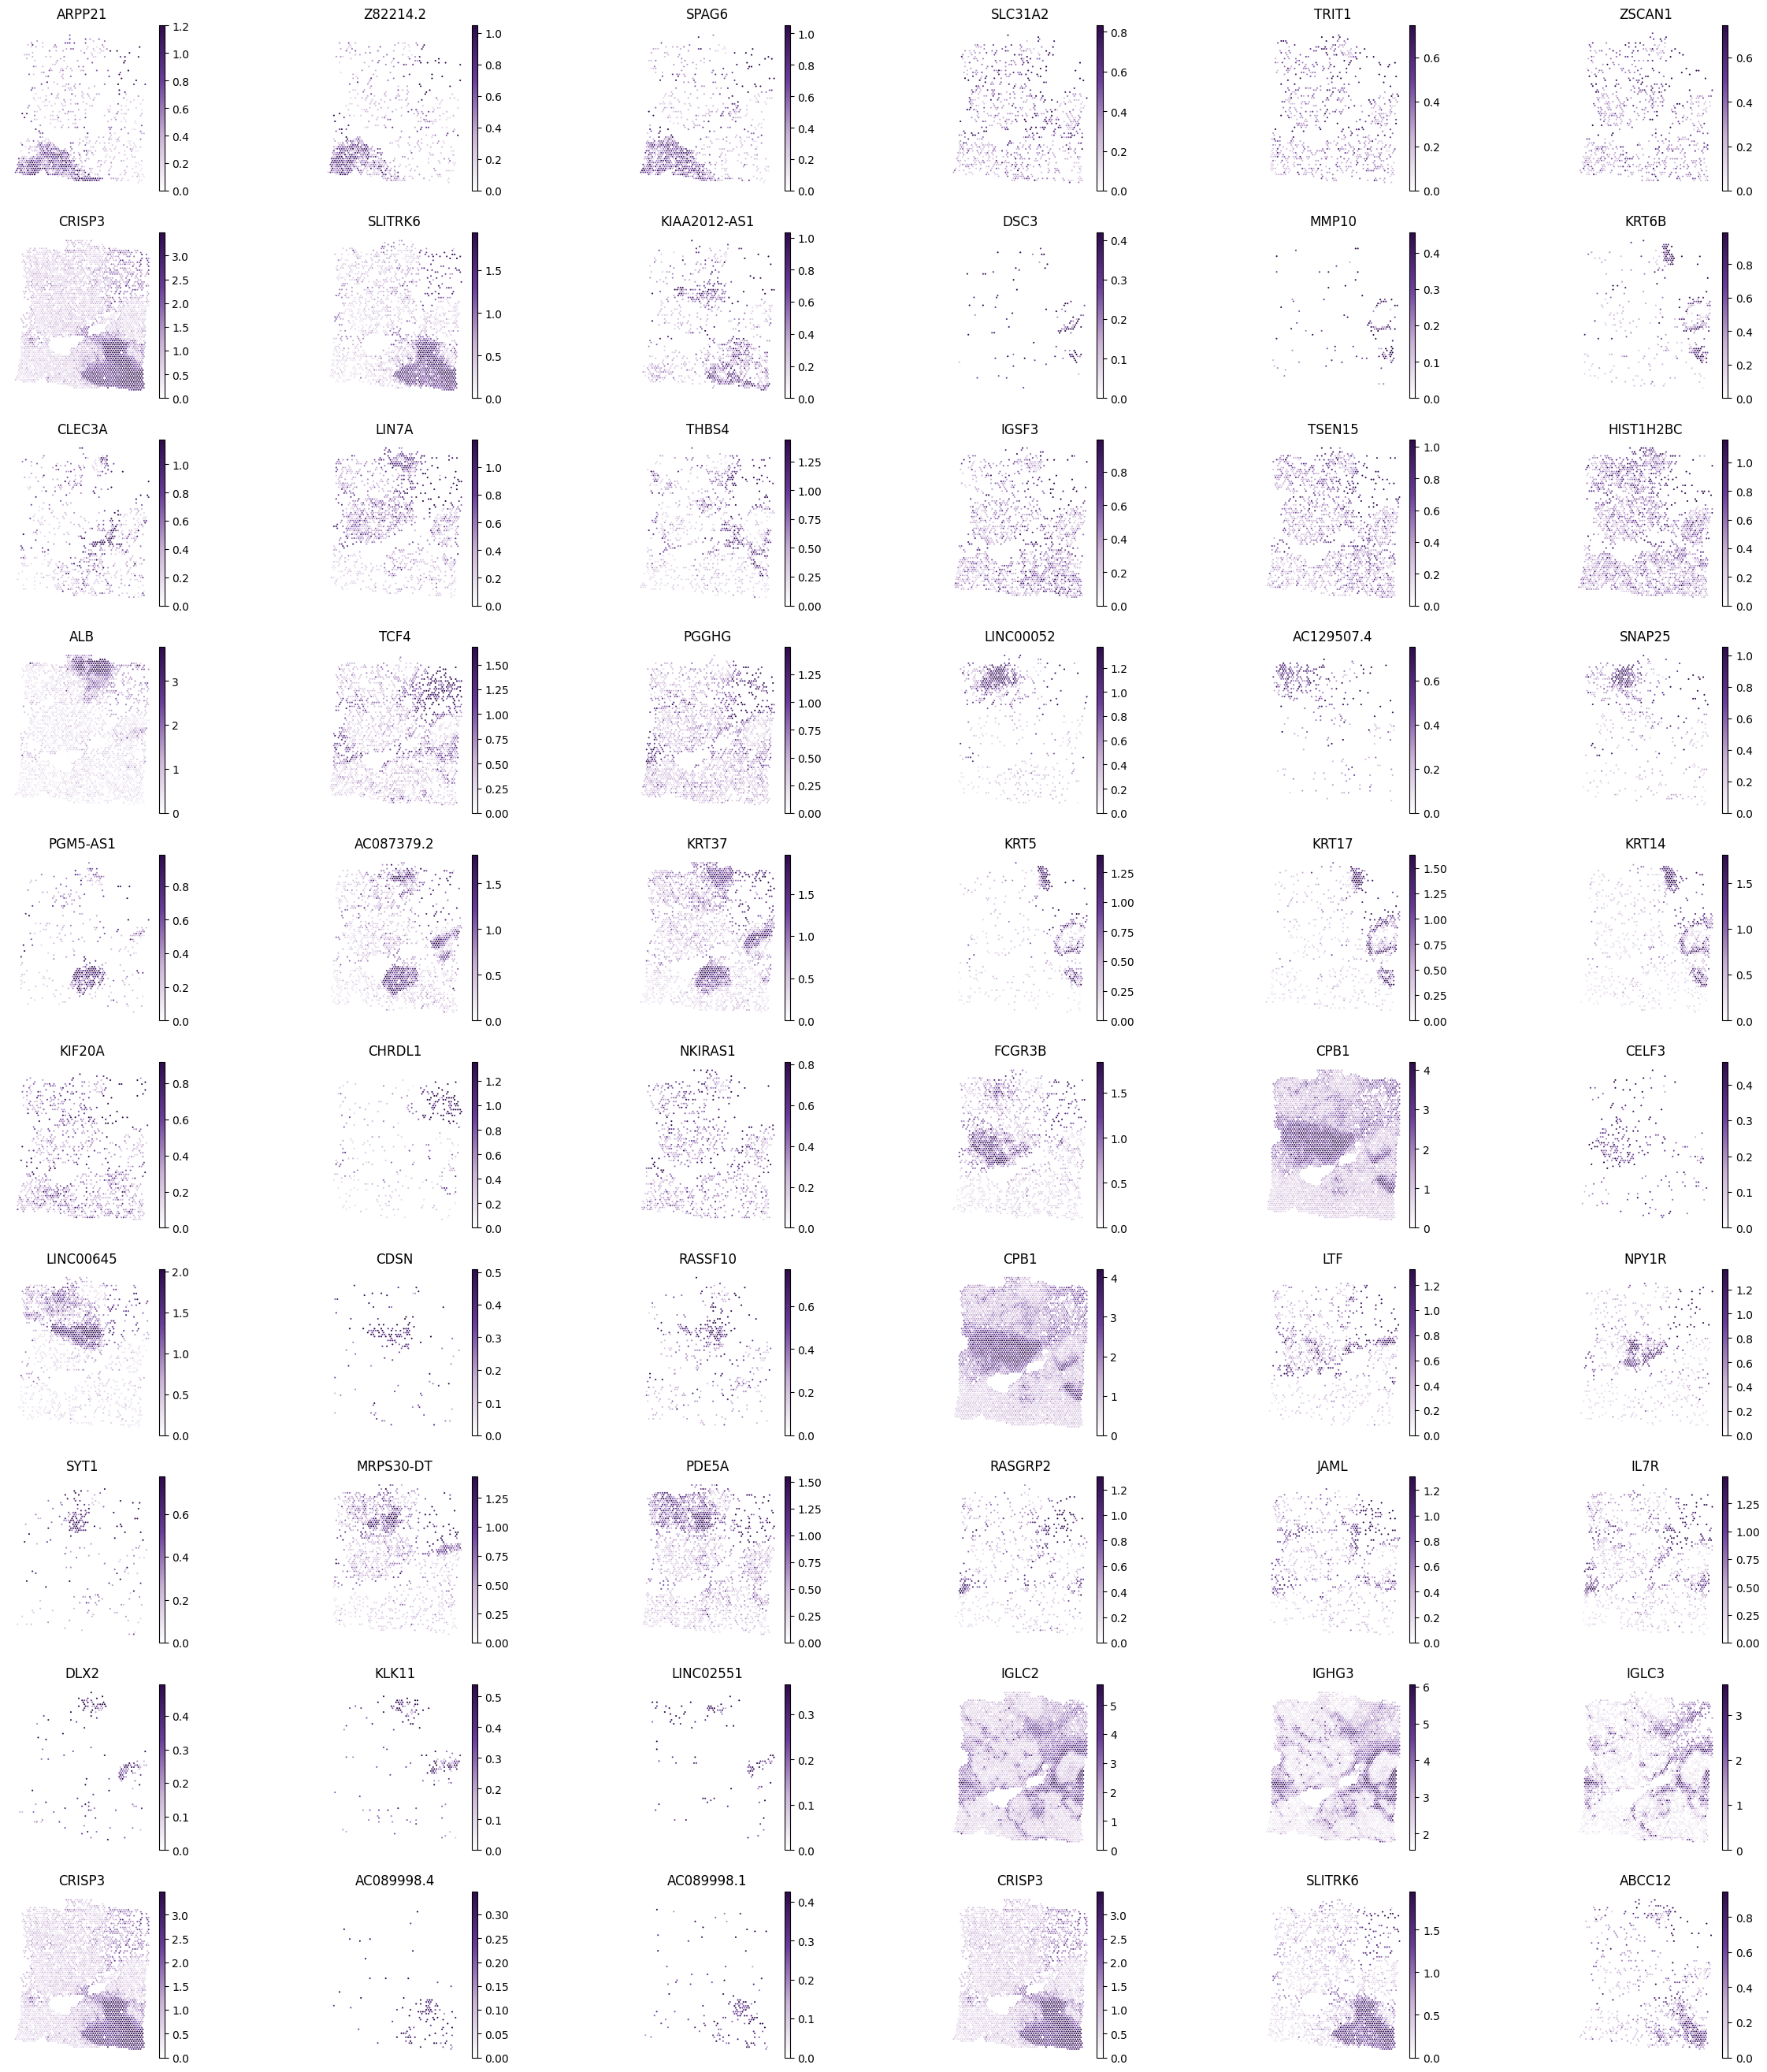

In [15]:
import scanpy as sc
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

colors = ["#FFFFFF", "#CAB2D6", "#6A3D9B", "#2E0A4B"]
custom_cmap = LinearSegmentedColormap.from_list("graphst_cmap", colors)

plt.rcParams.update({
    'figure.facecolor': 'white',   
    'savefig.facecolor': 'white',  
    'axes.facecolor': 'white',     
    'axes.edgecolor': 'black',     
    'axes.labelcolor': 'black',    
    'xtick.color': 'black',        
    'ytick.color': 'black',
})

fig = sc.pl.spatial(
    adata,
    color=selected_genes,
    ncols=6,
    spot_size=200,
    img_key=None,
    cmap=custom_cmap,
    vmin='p1',
    vmax='p99',
    frameon=False,    
    return_fig=True,
    show=False
)

for ax in fig.axes:
    ax.set_facecolor('white')

# fig.savefig(
#     f'clust_{n_markers}_white.png',
#     dpi=600,
#     bbox_inches='tight',
#     facecolor='white',   
#     pad_inches=0
# )

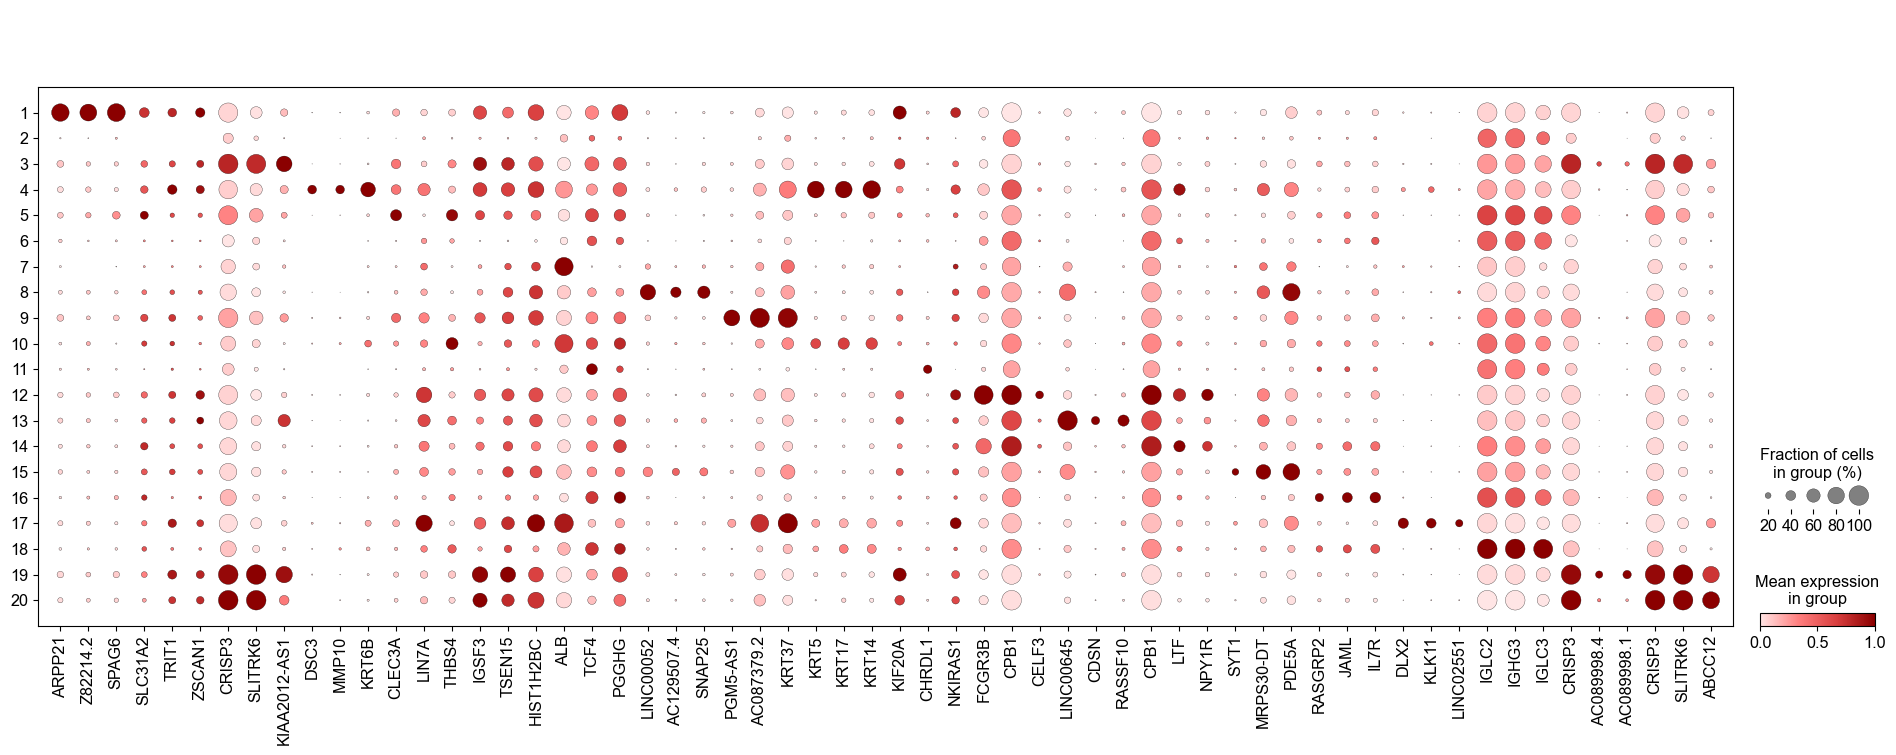

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc

matplotlib.rcParams.update({
    'font.family': 'Arial',
    'font.size': 14,
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.titlecolor': 'black',
    'figure.facecolor': 'white',  
    'axes.facecolor': 'white',    
    'savefig.facecolor': 'white'
})


custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "custom_gradient", 
    ["#FFE5E5", "#FF7F7F", "#D93F3F", "#8B0000"]
)


dot_plot = sc.pl.DotPlot(
    adata,
    var_names=selected_genes,
    groupby='HDVAE_clust',
    standard_scale='var',
    cmap=custom_cmap,
    vmin=0,
    vmax=1
)


dot_plot.make_figure()
for ax in plt.gcf().axes:
    ax.set_facecolor('white')

# plt.savefig(
#     f'dot_plot_{n_markers}_white.png',
#     bbox_inches='tight',
#     dpi=600,
#     facecolor='white',
#     pad_inches=0
# )